In [1]:
# # Mount to Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # Move to your current working directory
# %cd drive/MyDrive/Colab\ Notebooks/Cars

In [2]:
# Import all the packages
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

In [3]:
# Build one of the main components - DoubleConv - for UNet
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

In [4]:
# Build UNet from scrach
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
            self.ups.append(DoubleConv(feature*2, feature))
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down (x)
            skip_connections.append(x)
            x = F.max_pool2d(x, (2, 2))
        x = self.bottleneck(x)
        skip_connections.reverse()
        for i in range(0, len(self.ups), 2):
            x = self.ups [i](x)
            skip_connection = skip_connections[i//2]
            concat = torch.cat((skip_connection, x), dim=1) # N x C x H x W
            x = self.ups[i+1](concat)
        return self.final_conv(x)

In [5]:
# Create an UNet model object
model = UNet()
DDHDAS_data = torch.ones((16, 3, 512, 512))
output = model(DDHDAS_data)
print(output.shape)
# Move the model to GPU
# model = model.cuda()

torch.Size([16, 1, 512, 512])


In [6]:
# Build CustomDataset for loading data from Google Drive
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace('.bmp', '.png'))
        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path).convert('L'))
        return self.transform(image), self.transform(mask)

In [7]:
# Check the device we are using is GPU or CPU
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

cpu


In [8]:
# Constants for UNet model training process
BATCH_SIZE = 16
NUM_EPOCHS = 10
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [23]:
# Load data
all_data = CustomDataset(r"C:\Users\Ryan\Desktop\標記測試\unet\dataset\left\resize_image", r"C:\Users\Ryan\Desktop\標記測試\unet\dataset\left\resize_mask", 
                         T.Compose([T.ToTensor(), T.Resize((IMG_HEIGHT, IMG_WIDTH))]))

In [24]:
# Split data into train and val
train_data, val_data = torch.utils.data.random_split(all_data, [0.7, 0.3])

In [18]:
# Create loader for mini-batch gradient descent
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# The loss function for bianry classification
loss_function = nn.BCELoss()

# Choosing Adam as our optimizer
# optimizer = optim.Adam(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
def train(model, num_epochs, train_loader, optimizer, print_every=30):
  for epoch in range(num_epochs):
    for count, (x, y) in enumerate(train_loader):
      model.train()
      x = x.to(device)
      y = y.to(device)
      out = model(x)
      if count % print_every == 0:
        eval(model, val_loader, epoch)
      out = torch.sigmoid(out)
      loss = loss_function(out, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

In [21]:
def eval(model, val_loader, epoch):
  model.eval()
  num_correct = 0
  num_pixels = 0
  with torch.no_grad():
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)
      out_img = model(x)
      probability = torch.sigmoid(out_img)
      predictions = probability>0.5
      num_correct += (predictions==y).sum()
      num_pixels += BATCH_SIZE*IMG_WIDTH*IMG_HEIGHT
  print(f'Epoch[{epoch+1}] Acc: {num_correct/num_pixels}')


In [ ]:
train(model, NUM_EPOCHS, train_loader, optimizer)
torch.save(model.state_dict(), 'unet_model.pth')

In [ ]:
def final_evaluation(model, val_loader):
    model.eval()
    num_correct = 0
    num_pixels = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            out_img = model(x)
            probability = torch.sigmoid(out_img)
            predictions = probability > 0.5
            num_correct += (predictions == y).sum()
            num_pixels += torch.numel(predictions)
    print(f'最终准确率: {num_correct/num_pixels:.4f}')

final_evaluation(model, val_loader)

最终准确率: 0.9981


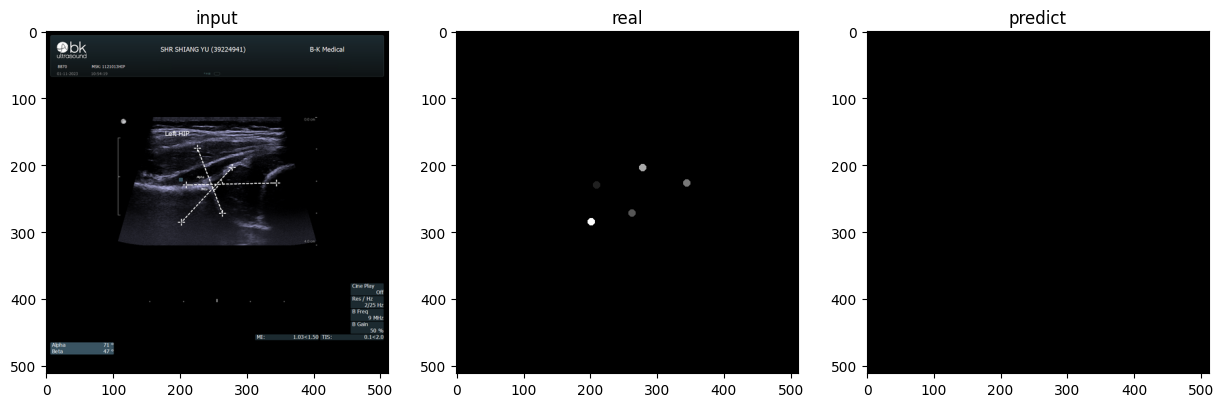

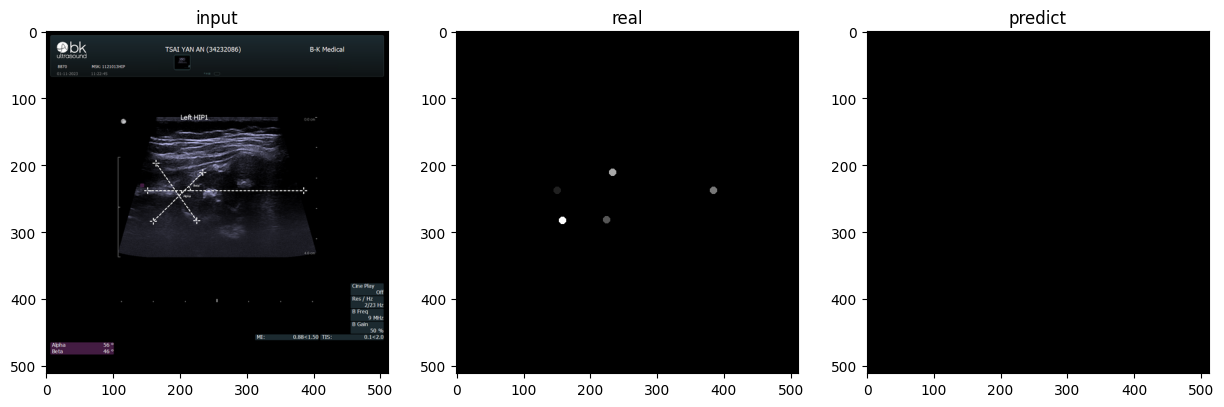

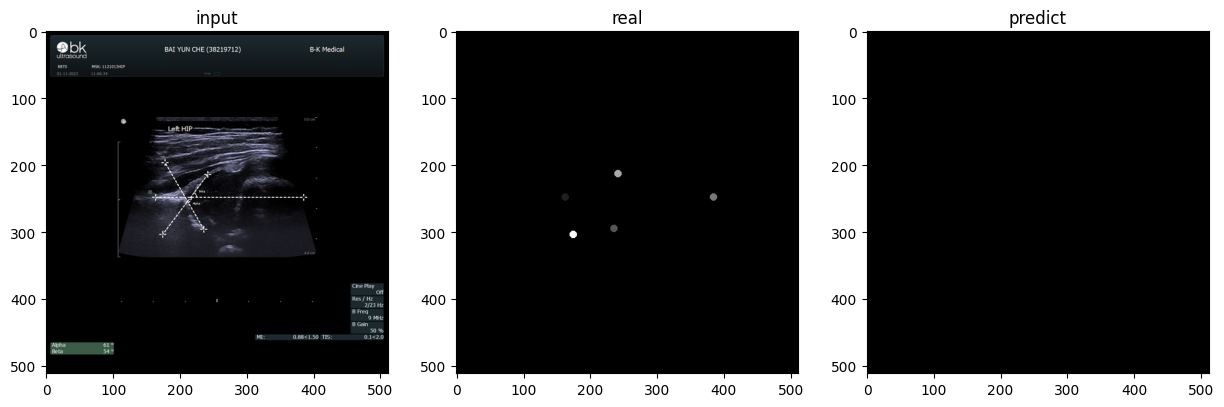

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, val_loader, num_samples=3):
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            out_img = model(x)
            probability = torch.sigmoid(out_img)
            predictions = probability > 0.5
            
            for i in range(num_samples):
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(x[i].cpu().permute(1, 2, 0))
                plt.title('input')
                plt.subplot(1, 3, 2)
                plt.imshow(y[i].cpu().squeeze(), cmap='gray')
                plt.title('real')
                plt.subplot(1, 3, 3)
                plt.imshow(predictions[i].cpu().squeeze(), cmap='gray')
                plt.title('predict')
                plt.show()
            break

visualize_predictions(model, val_loader)